# Tools to Help Plan NIRSpec IFU Observations

This notebook demonstrates how to use some tools in ``breads`` to help plan JWST NIRSpec IFU observations. 

In [1]:
%pylab inline
import astropy.units as u
import breads.jwst_tools.planning as jw_planning
import breads.utils

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## Visualizing JWST IFU FOVs and diffraction spikes. 

This example is based on the program 1414 obs of HD 19467 B.

Use `visualize_nrs_fov` to depict where a companion will fall relative to NIRSpec IFU FOV and PSF diffraction features, and also the potential effects of saturated pixels around a bright PSF core. (Note, this quick tool does NOT assess saturation, instead use the ETC for that. This just flags which slices are most likely to have an issue with that.)

You need to tell this function the relative position of the companion, and a desired V3PA position angle for JWST. 

Offset star by 0.000, 0.000 arcsec in (V2, V3) frame.
Aperture NRS_FULL_IFU has V3IdlYAngle =  138.972
For V3PA = 211.0, NIRSpec NRS_FULL_IFU aperture PA (including pipeline IFUAlign rotation) is 260.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 23.97 from the star
   Therefore star is oriented to local aperture angle 203.97 from the companion
    (for stpsf sim use offset -0.650, -1.462 arcsec) 
Caution: NRS_IFU_SLICE00 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE01 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE03 contains the PSF core, and may have saturated pixels and increased noise 


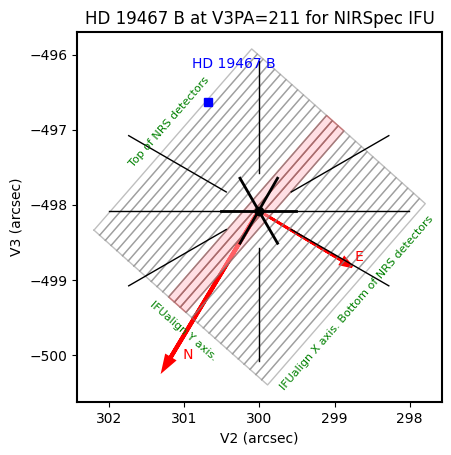

In [2]:
jw_planning.visualize_nrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                              v3pa=211, verbose=True)


The plot is oriented and labeled in the overall coordinate system of JWST's focal plane, the so-called V frame. See [this JDox page](https://jwst-docs.stsci.edu/jwst-observatory-hardware/jwst-telescope/jwst-focal-plane#gsc.tab=0) for description of that frame.  The NIRSpec IFU FOV is rotated about 140 deg relative to that frame. 

The plot also indicates which sides of the FOV correspond to the X and Y axes in pipeline-processed s3d datacubes *in the IFUAlign* frame. See pipeline cube build documentation for details. Note, the IFUAlign outputs have a semi-arbitrary 90 degree rotation in the cubes; the "X" axis in IFUAlign cubes actually corresponds to the "Y" axis in NIRSpec detector pixels. This can be a subtle annoyance. 

That PA works pretty well to have the companion away from the spikes, but the companion ends up too close to the edge. 

## Offset pointings with the NIRSpec IFU


Let's recenter the IFU to point at the companion, using the `center_on` keyword.

Offset star by -0.676, -1.450 arcsec in (V2, V3) frame.
Aperture NRS_FULL_IFU has V3IdlYAngle =  138.972
For V3PA = 211.0, NIRSpec NRS_FULL_IFU aperture PA (including pipeline IFUAlign rotation) is 260.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 23.97 from the star
   Therefore star is oriented to local aperture angle 203.97 from the companion
    (for stpsf sim use offset -0.650, -1.462 arcsec) 
Caution: NRS_IFU_SLICE24 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE26 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE28 contains the PSF core, and may have saturated pixels and increased noise 


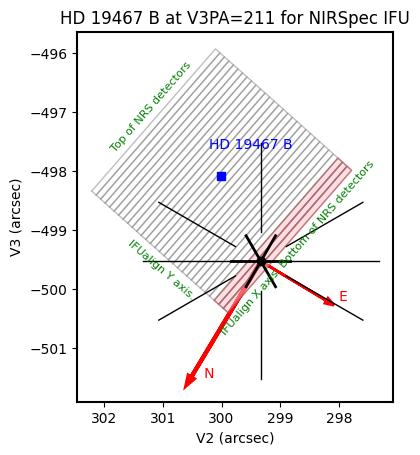

In [3]:
jw_planning.visualize_nrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                              v3pa=211, verbose=True,
                             center_on='comp')


You can also specify an arbitrary offset for the star, with the parameter ``offset_star = (dx, dy)``.

**Important note:** This function takes offsets in (∆V2, ∆V3) **V frame** coordinates; this is NOT THE SAME as the coordinates you'd need to use in APT to achieve this, which needs to be specified in **instrument coordinartes**. So be careful about rotation angles!


Offset star by -0.200, -1.500 arcsec in (V2, V3) frame.
Aperture NRS_FULL_IFU has V3IdlYAngle =  138.972
For V3PA = 211.0, NIRSpec NRS_FULL_IFU aperture PA (including pipeline IFUAlign rotation) is 260.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 23.97 from the star
   Therefore star is oriented to local aperture angle 203.97 from the companion
    (for stpsf sim use offset -0.650, -1.462 arcsec) 
Caution: NRS_IFU_SLICE18 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE20 contains the PSF core, and may have saturated pixels and increased noise 
Caution: NRS_IFU_SLICE22 contains the PSF core, and may have saturated pixels and increased noise 


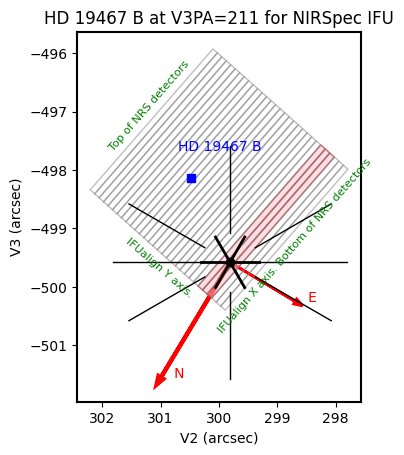

In [4]:
jw_planning.visualize_nrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                              v3pa=211, verbose=True,
                              offset_star=(-0.2, -1.5)) 

If we want to do that, how can we most tell JWST to do that? Two options:

 - Set a relative offset special requirement on the observation. This is **tricky to get right** because (a) That special requirement offset is specified in the *local aperture coordinate system* of the IFU, which is rotated ~140 degrees relative to the V frame for NIRSpec IFU, so you need to do a coordinate rotation. And furthermore, (b) That offset then depends on the position angle of the observatory, so if you have a PA range or if you have two rolls for ADI, you need to compute the offset SRs depending on the specific PAs used.  
 - Alternatively, just tell JWST to point the IFU at the absolute RA and Dec which correspond to the expected position of the companion. (We usually think about companion astrometry as relative to the star, but we can just convert to absolute astrometry in the ICRS frame.)

Both approaches have pros and cons, so pick whichever you prefer for your science program.

## Computing absolute coordinates for offset pointings

``breads`` has a function to compute the absolute coordinates of a companion for you. This is ``companion_relative_to_absolute_position``.  It returns an ``astropy.coords.SkyCoord`` object with the ICRS coordinates of the companion.  It also helpfully prints out the information you would need to enter into APT. Make sure to get the proper motion and epoch correct!!

In [5]:
breads.utils.companion_relative_to_absolute_position('HD 19467', 
                                                     comp_name = 'HD 19467 B', 
                                                     comp_sep = 1.6*u.arcsec,
                                                     comp_pa = 236*u.deg, 
                                                     obs_date = '2023-01-20')

**HOST STAR:**
Retrieving SIMBAD coordinates for HD 19467
Coordinates at J2000:  03h07m18.57505144s -13d45m42.41798215s
Coordinates at 2023-01-20:  03h07m18.56129591s -13d45m48.42612868s
Proper motion  pm_ra_cosdec: -8.694 mas / yr	pm_dec: -260.642 mas / yr
Parallax : 31.219 mas

**COMPANION:**
HD 19467 B has r=1.6 arcsec, pa=236.0 deg, which is (dDec,dR.A.) = -0.895 arcsec, -1.326 arcsec
HD 19467 B ICRS coords at 2023-01-20: 03h07m18.4702509s -13d45m49.32083628s

        Crosscheck PA: 236.000 deg  should equal 236.0 deg
        Crosscheck sep: 1.600000 arcsec  should equal 1.6 arcsec 
        if the above are not equal then something went wrong in this calculation. 

**COMPANION ABSOLUTE POINTING INFO FOR APT:**
	Name:			HD 19467 B
	ICRS coordinates:	03 07 18.4702509 -13 45 49.32083628
	Epoch:			2023.05
	Proper Motion:		RA: -8.694 mas / yr	Dec: -260.642 mas / yr
	Annual Parallax:	0.0312 arcsec


<SkyCoord (ICRS): (ra, dec) in deg
    (46.82695938, -13.76370023)>

## And similarly for MIRI MRS too

There is now also a function for plotting MIRI MRS like this too. Use ``visualize_miri_mrs_fov``.  This has a ``mrs_band`` parameter so you can select which of the 4 channels times 3 sub-bands should be shown. For instance set ``mrs_band='3B'``.

Offset star by 0.000, 0.000 arcsec in (V2, V3) frame.
Aperture MIRIFU_CHANNEL2A has V3IdlYAngle =  0.000
For V3PA = 211.0, MIRI MIRIFU_CHANNEL2A aperture PA (including pipeline IFUAlign rotation) is 211.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 335.00 from the star
   Therefore star is oriented to local aperture angle 155.00 from the companion
    (for stpsf sim use offset 0.676, -1.450 arcsec) 
Caution: MIRIFU_2ASLICE08 contains the PSF core, and may have saturated pixels and increased noise 
Caution: MIRIFU_2ASLICE09 contains the PSF core, and may have saturated pixels and increased noise 
Caution: MIRIFU_2ASLICE10 contains the PSF core, and may have saturated pixels and increased noise 


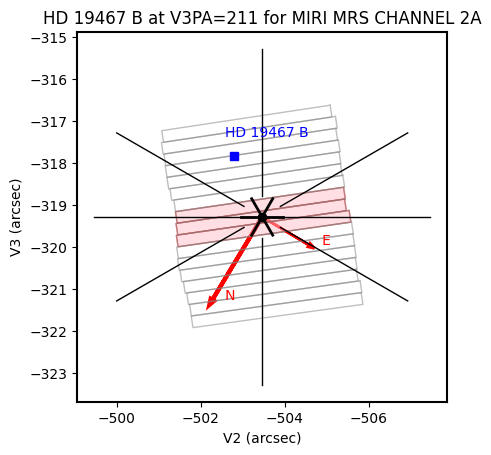

In [6]:
jw_planning.visualize_miri_mrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                              v3pa=211, verbose=True,  psf_core_check_radius=1)


Offset star by -0.676, -1.450 arcsec in (V2, V3) frame.
Aperture MIRIFU_CHANNEL4A has V3IdlYAngle =  0.000
For V3PA = 211.0, MIRI MIRIFU_CHANNEL4A aperture PA (including pipeline IFUAlign rotation) is 211.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 335.00 from the star
   Therefore star is oriented to local aperture angle 155.00 from the companion
    (for stpsf sim use offset 0.676, -1.450 arcsec) 
Caution: MIRIFU_4ASLICE09 contains the PSF core, and may have saturated pixels and increased noise 


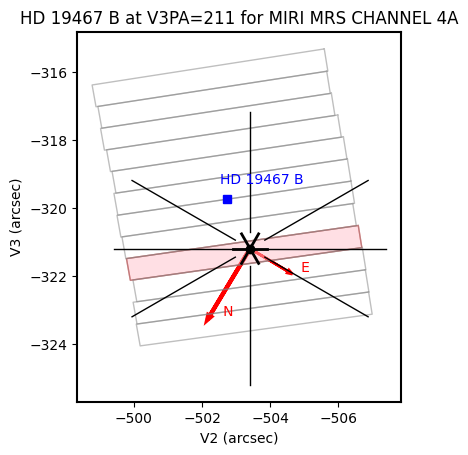

In [7]:
jw_planning.visualize_miri_mrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                                   mrs_band='4A',
                              v3pa=211, verbose=True, psf_core_check_radius=1, center_on='comp')


# Higher Fidelity Mock IFU Scenes

The above is intentionally simple and cartoony. If you want a higher fidelity view of what the data may look like, with more rigorous depiction of the diffraction features and speckles, use ``calc_mock_ifu_slice``.

Unlike the above, which can only deal with 1 companion, this function takes as input a dictionary ``companion_info``, which allows specifying properties for multiple companions.  For each companion it should contain a dictionary that gives ``r``, ``pa``, and either ``contrast`` as a scalar or ``contrast_function`` a function that returns the contrast based on wavelength. 

Like STPSF, wavelengths must be specified in SI units, so for e.g. 4 microns either use `4e-6` or ``4*u.micron``.

Generating mock scene for NIRSpec IFU at 5000000.0 micron microns, using IFU FOV = 30 pixels ...
V3PA=211, therefore instrument aperture PA=260.0
Calculating stellar PSF at offset = (-0.65, -1.462)
Calculating comp B PSF at offset = 0.65, 1.46 from the star
  Comp B modeled with contrast ~ 1.00e-03


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x31c4ce6f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x31dce2960>, <astropy.io.fits.hdu.image.ImageHDU object at 0x31dce1700>, <astropy.io.fits.hdu.image.ImageHDU object at 0x31dce1eb0>]

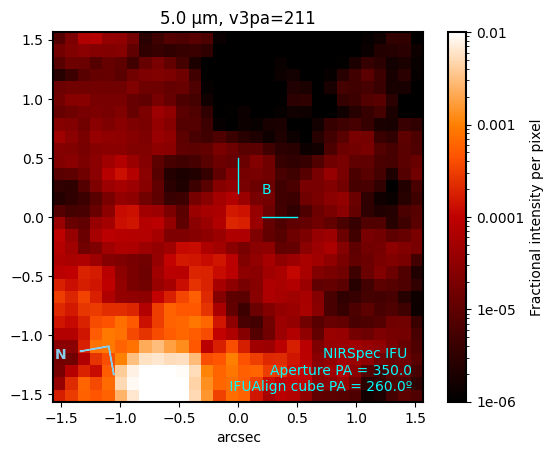

In [8]:
comp_info = {'B': {'r':  1.6*u.arcsec, 'pa': 236*u.deg, 'contrast': 1e-3}}
star_offset = (-0.650, -1.462)  # value printed out from visualize_nrs_fov

jw_planning.calc_mock_ifu_slice(v3pa=211, companion_info=comp_info, star_offset=star_offset)

Let's compare the simple and detailed visualizations side by side. You should be able to see how the two images depict the same geometry, with a little bit of mental rotation to account for the tilted orientation of the NIRSpec IFU in the left panel. 

Generating mock scene for NIRSpec IFU at 5000000.0 micron microns, using IFU FOV = 30 pixels ...
V3PA=211, therefore instrument aperture PA=260.0
Calculating stellar PSF at offset = (-0.65, -1.462)
Calculating comp B PSF at offset = 0.65, 1.46 from the star
  Comp B modeled with contrast ~ 1.00e-03


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x34f87f7d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x34f87ea20>, <astropy.io.fits.hdu.image.ImageHDU object at 0x34f90c2c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x34f90ea20>]

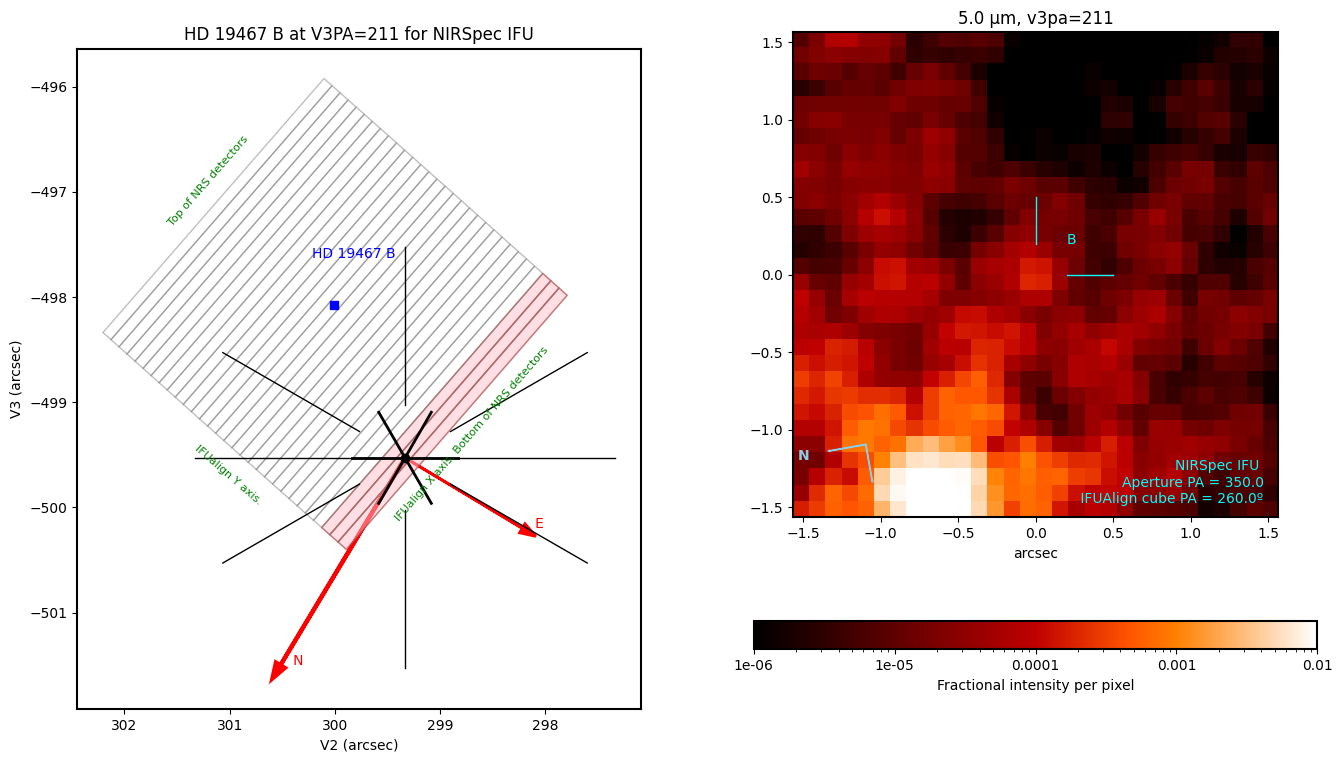

In [9]:
fig, axes = plt.subplots(figsize=(16,9), ncols = 2)

jw_planning.visualize_nrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, 
                              v3pa=211, verbose=False,
                              ax=axes[0],
                              center_on='comp')
jw_planning.calc_mock_ifu_slice(v3pa=211, companion_info=comp_info, star_offset=star_offset,
                               ax=axes[1],
                               colorbar_orientation='horizontal')

### And for MIRI too:

Using MRS slice width is 0.28 for PSF core check
Offset star by -0.676, -1.450 arcsec in (V2, V3) frame.
Aperture MIRIFU_CHANNEL2A has V3IdlYAngle =  0.000
For V3PA = 211.0, MIRI MIRIFU_CHANNEL2A aperture PA (including pipeline IFUAlign rotation) is 211.0
   Therefore companion PA (236.00 deg) is oriented to local aperture angle 335.00 from the star
   Therefore star is oriented to local aperture angle 155.00 from the companion
    (for stpsf sim use offset 0.676, -1.450 arcsec) 
Generating mock scene for MIRI MRS band 1A at 5000000.0 micron microns, using IFU FOV = [28 25] pixels ...
V3PA=211, therefore instrument aperture PA=219.4
Calculating stellar PSF at offset = (0.676, -1.45)


/Users/mperrin/Dropbox (Personal)/Documents/software/stpsf/stpsf/opds.py:1776: UserWarning: For (V2,V3) = [-8.38963333 -5.31665333] arcmin, Field point -8.254199999999999 arcmin, -2.4833466666666677 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.1354333333333333 arcmin away from the requested coordinates.
  warnings.warn(warning_message)


Calculating comp B PSF at offset = -0.46, 1.53 from the star
  Comp B modeled with contrast ~ 1.00e-03


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x34f7ec380>, <astropy.io.fits.hdu.image.ImageHDU object at 0x34f856e40>, <astropy.io.fits.hdu.image.ImageHDU object at 0x31d7eafc0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x34f778bc0>]

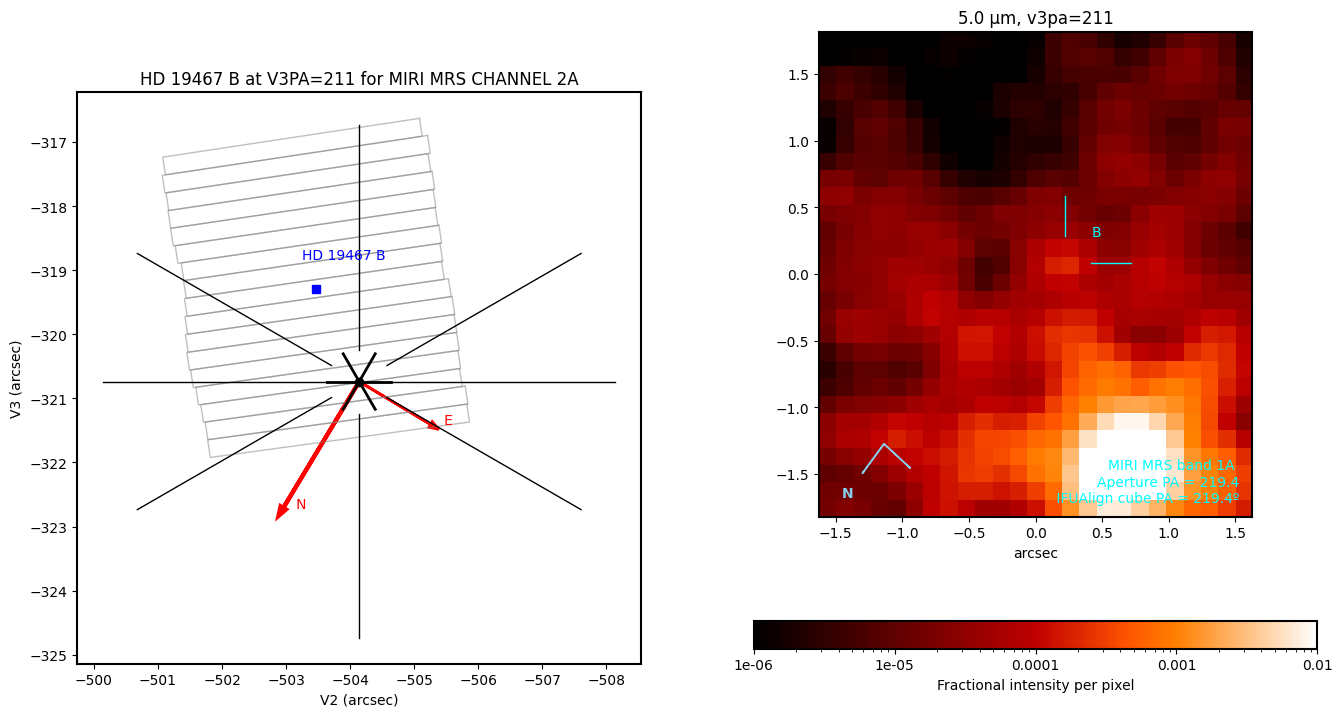

In [10]:
star_offset_miri = (0.676, -1.450)  # value printed out from visualize_miri_mrs_fov

fig, axes = plt.subplots(figsize=(16,9), ncols = 2)
jw_planning.visualize_miri_mrs_fov(comp_name = 'HD 19467 B', 
                              comp_sep = 1.6*u.arcsec,
                              comp_pa = 236*u.deg, center_on='comp',
                              v3pa=211, verbose=True,  ax=axes[0])

jw_planning.calc_mock_ifu_slice('MIRI', v3pa=211, companion_info=comp_info, star_offset=star_offset_miri,
                               ax=axes[1],
                               colorbar_orientation='horizontal')

### An example with multiple companions

Here we generate a mock image corresponding to the observation of YSES 1 in program 2044 observation 1. 

Compare with the actual data published in [Hoch et al. 2025, figure 1](https://ui.adsabs.harvard.edu/abs/2025Natur.643..938H/abstract). Note that for cosmetic reasons there was a 90 degree rotation counterclockwise applied to the data when making that figure, so the image there is rotated relative to this one here. But you can see the same PSF features and companion positions in any case. 

Generating mock scene for NIRSpec IFU at 4000000.0 micron microns, using IFU FOV = 30 pixels ...
V3PA=78, therefore instrument aperture PA=127.0
Calculating stellar PSF at offset = (2.1, -0.5)
Calculating comp b PSF at offset = -1.70, 0.15 from the star
  Comp b modeled with contrast ~ 1.00e-02
Calculating comp c PSF at offset = -3.36, -0.24 from the star
  Comp c modeled with contrast ~ 6.00e-04


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x357bf9520>, <astropy.io.fits.hdu.image.ImageHDU object at 0x357338890>, <astropy.io.fits.hdu.image.ImageHDU object at 0x35733bd10>, <astropy.io.fits.hdu.image.ImageHDU object at 0x35733a7e0>]

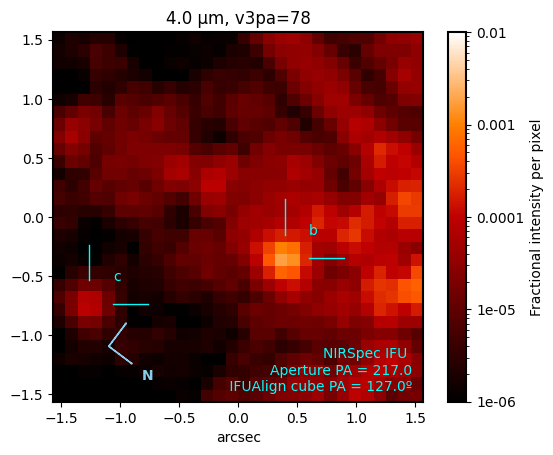

In [30]:
yses_1_comps = {'b': {'r':1.708*u.arcsec, 'pa':212*u.deg,   'contrast': 1e-2, },
                'c': {'r': 3.369*u.arcsec, 'pa': 221*u.deg, 'contrast': 6e-4}
               }

yses_1_star_offset = (2.1, -0.5)

jw_planning.calc_mock_ifu_slice(v3pa=78, companion_info=yses_1_comps, star_offset=yses_1_star_offset, wavelength=4*u.micron)

In [ ]:
calc_mock_ifu_slice('MIRI', mrs_band='2A', v3pa=0, wavelength=8e-6)

In [ ]:
calc_mock_ifu_slice('MIRI', mrs_band='3A', v3pa=0, wavelength=14e-6)